In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [55]:
def coth(a):
    if a>0: return (1+np.exp(-2*a))/(1-np.exp(-2*a))
    if a<0: return (np.exp(2*a)+1)/(np.exp(2*a)-1)
    if a==0: return 0

m2=-1.0
lamb=1.0
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
h_real=np.array([3*coth(3*((i-N_layer)*del_eta)) for i in range (N_layer)])

def LP2(hh, phi, pi):
    for j in range (N_layer-1):
        phi1=phi+del_eta*pi
        pi1 =phi*m2*del_eta+(1-del_eta*hh[j])*pi+del_eta*lamb*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi

def F_func(a,b):
    return 2*b/eta_fin-m2*a-lamb*(a**3)

def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

def generate_data(datasize=1000, Hrange=[0.0, 1.5], Mrange=[-0.2, 0.2]):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1], datasize)
        M=np.random.uniform(Mrange[0], Mrange[1], datasize)
        HH, MM = LP2(h_real, H, M)
        F=np.array(np.abs(F_func(HH, MM)))
        for i in range (len(H[F<0.1])):
            if len(Fp)>=datasize: break
            Hp.append([H[F<0.1][i]])
            Mp.append([M[F<0.1][i]])
            Fp.append([0])
        for j in range (len(H[F>=0.1])):
            if len(Fn)>=datasize: break
            Hn.append([H[F>=0.1][j]])
            Mn.append([M[F>=0.1][j]])
            Fn.append([1])
        if len(Fp)>=datasize and len(Fn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(Positive_HM, Negative_HM):
    print(len(Positive_HM[2]), len(Negative_HM[2]))
    plt.xlabel('phi')
    plt.ylabel('pi')
    plt.plot(Negative_HM[0], Negative_HM[1], 'g.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'r.', label='positive')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

1000 1000


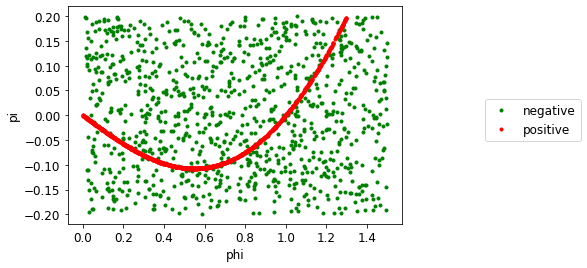

In [56]:
positive_H_M_F, negative_H_M_F = generate_data(datasize=1000)
plot_all(Positive_HM, Negative_HM)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [57]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [58]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [59]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, m2=None, lamb=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        
        #fixed parameters
        self.lamb=lamb
        self.m2=m2
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.one=Variable(torch.ones(1))

    def show_Hs(self):
        a=[]
        for i in range (N_layer):
            aa=self.Hs[i](self.one).data.numpy()[0]
            a.append(aa)
        return a
        
    def penalty(self, coef_list=None):
        pen=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            pen = pen + coefs[i]*(H(self.one) - pH)**2
            pH = H(self.one)
        return pen
        
    def forward(self, phi=None, Pi=None):# intermediate layers
        i=0
        for H in self.Hs:
            i=i+1
            if i==10: break
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb, del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model):
    for i in range (len(Model.Hs)):
        mu=1/(eta_ini+del_eta*i)
        w=np.random.normal(mu, 1)
        Model.Hs[i].weight.data.fill_(w) 

In [69]:
m2 = -1
lamb = 1
N_layer = 10
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(N_layer=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         lamb=lamb,
                         del_eta=del_eta)
init_weights(Test)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.003*eta(i, eta_ini, eta_fin, N_layer)**4)
print(Test.show_Hs())

[-0.15465395, 1.493116, 0.6086387, 1.2910969, 1.1107322, 1.2614173, 3.9151585, 3.0447416, 3.1984787, 5.043294]


# 3. Train your NN

In [70]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(n)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(p)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, h_real, 'r-')
    ar.plot(x, np.array(NN2_list), 'k-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=18)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

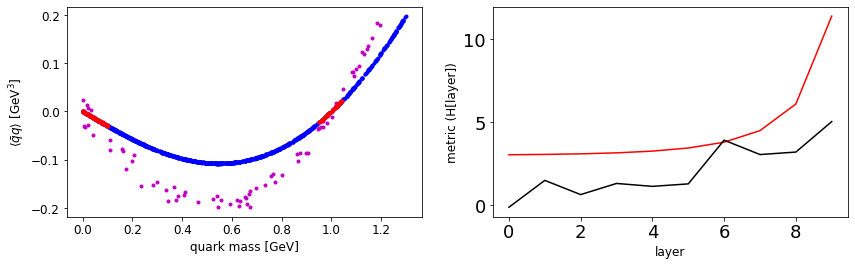

training epoch: 0,   loss: 0.2152250111103058
[-0.13675259, 1.4821491, 0.62590474, 1.2974288, 1.1215292, 1.2707288, 3.904981, 3.0382886, 3.1884594, 5.0233026]


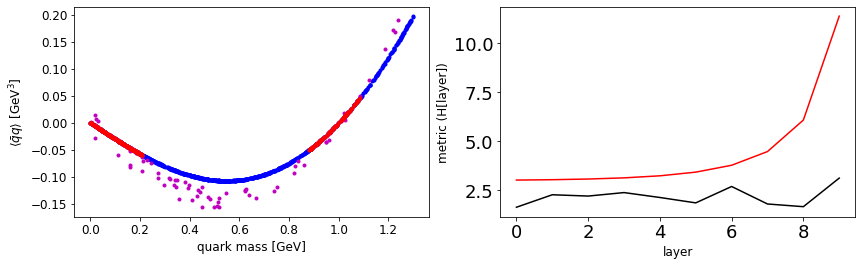

training epoch: 100,   loss: 0.11561493575572968
[1.6436567, 2.2798502, 2.213104, 2.3905706, 2.1405618, 1.8659481, 2.7006135, 1.8094739, 1.6724364, 3.1285908]


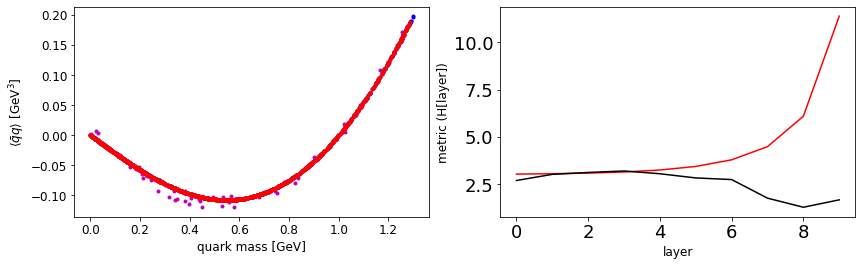

training epoch: 200,   loss: 0.0017965417355298996
[2.688671, 3.014529, 3.1155305, 3.1915567, 3.0458376, 2.8254557, 2.739503, 1.7563215, 1.2755208, 1.66612]


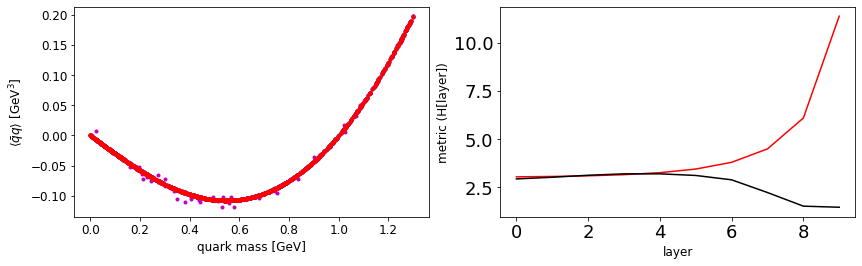

training epoch: 300,   loss: 0.0010905360104516149
[2.9193947, 3.0057917, 3.1102765, 3.1831555, 3.1834414, 3.0990622, 2.8728242, 2.2117665, 1.5040135, 1.4476454]


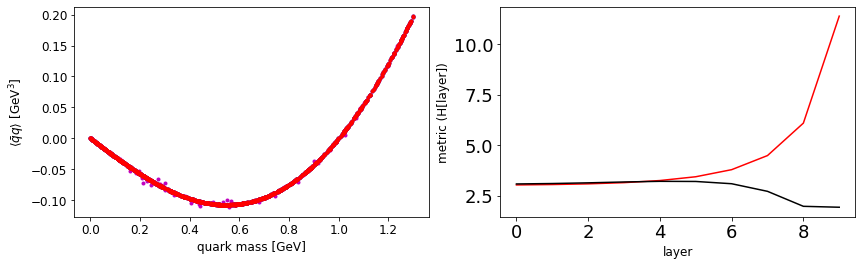

training epoch: 400,   loss: 0.0009444464230909944
[3.0753407, 3.0966566, 3.130768, 3.173161, 3.2059782, 3.1988924, 3.0867677, 2.7104983, 1.9693023, 1.9232801]


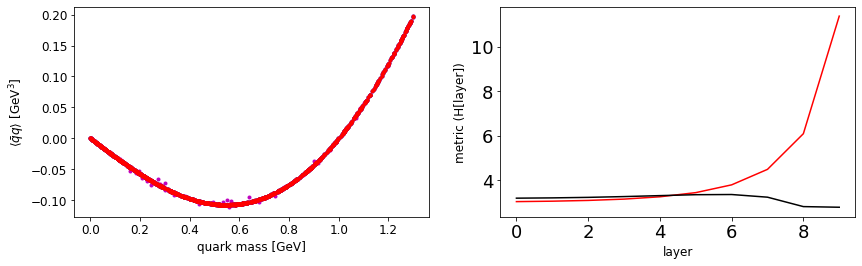

training epoch: 500,   loss: 0.0005991137004457414
[3.1825237, 3.195418, 3.2188995, 3.2541416, 3.2973325, 3.3388014, 3.347014, 3.2270362, 2.8030508, 2.773979]


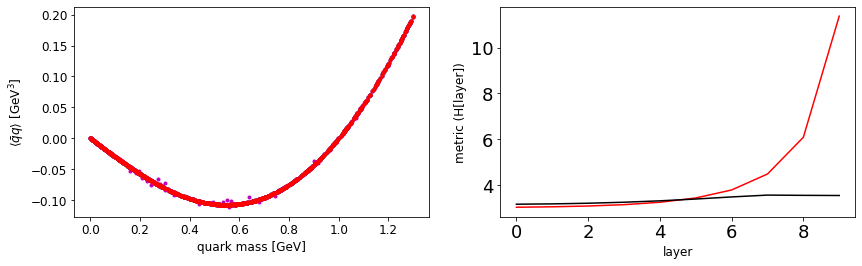

training epoch: 600,   loss: 0.0006696035852655768
[3.1596744, 3.1736844, 3.2022662, 3.2464602, 3.3076608, 3.3864355, 3.478089, 3.557899, 3.5473204, 3.540249]


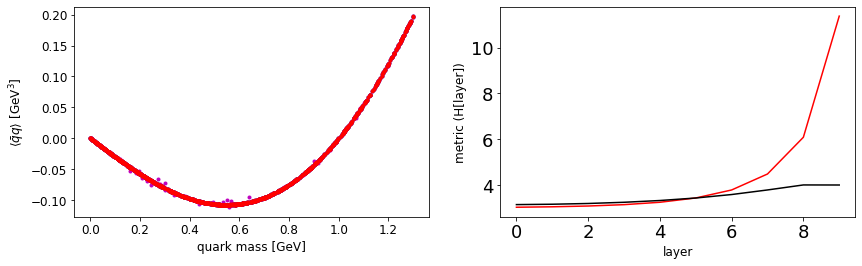

training epoch: 700,   loss: 0.0005995662650093436
[3.1428971, 3.1587155, 3.1914787, 3.244098, 3.321494, 3.4311283, 3.5827167, 3.7827117, 4.001822, 3.9991539]


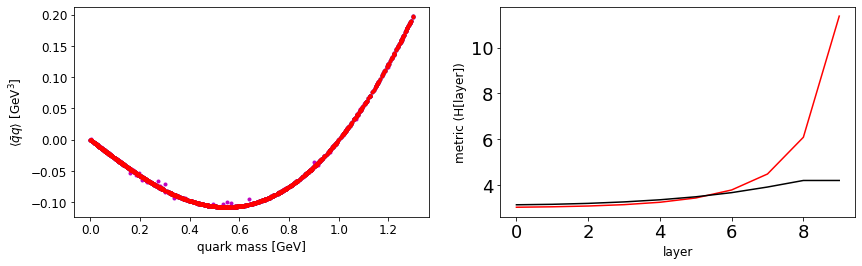

training epoch: 800,   loss: 0.0006280897650867701
[3.134898, 3.1552417, 3.1960552, 3.2601316, 3.35306, 3.4838858, 3.6655467, 3.9107203, 4.196948, 4.19732]


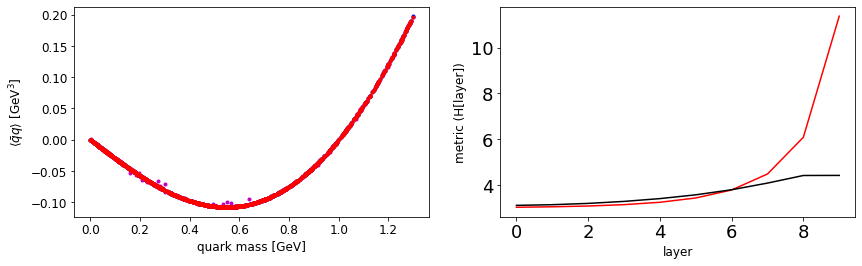

training epoch: 900,   loss: 0.0006400876445695758
[3.1095119, 3.138394, 3.1954343, 3.2825534, 3.4045784, 3.570139, 3.7921019, 4.0828857, 4.4151216, 4.4185886]


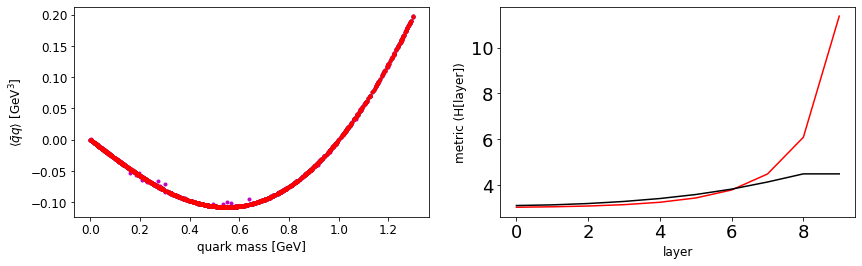

training epoch: 1000,   loss: 0.0005599943688139319
[3.101766, 3.1311283, 3.1899061, 3.2804813, 3.4084163, 3.5833387, 3.8193235, 4.12989, 4.485898, 4.4853787]


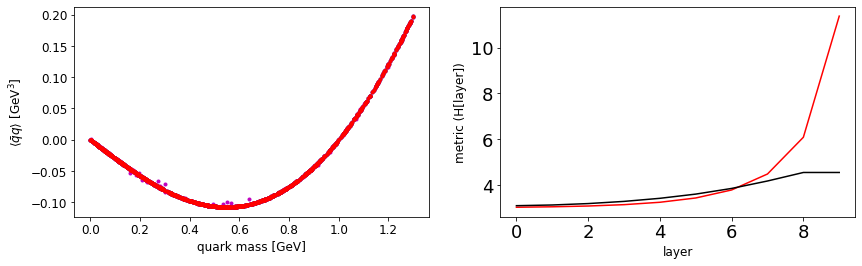

training epoch: 1100,   loss: 0.0005819700309075415
[3.095139, 3.1258729, 3.1876235, 3.2829833, 3.4177136, 3.6016724, 3.849294, 4.1744585, 4.54659, 4.5467515]


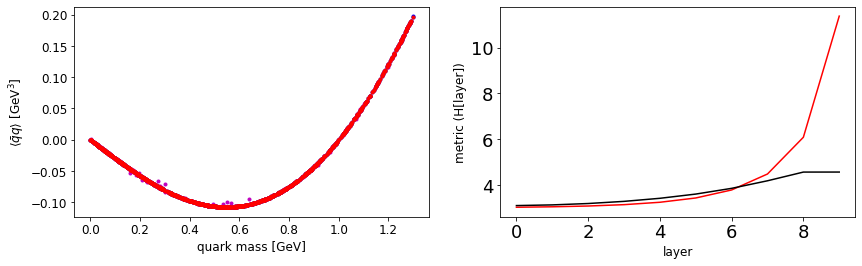

training epoch: 1200,   loss: 0.0005652771214954555
[3.1001987, 3.1298554, 3.1900718, 3.284087, 3.4181898, 3.6028128, 3.8531265, 4.1838403, 4.5640526, 4.5650105]


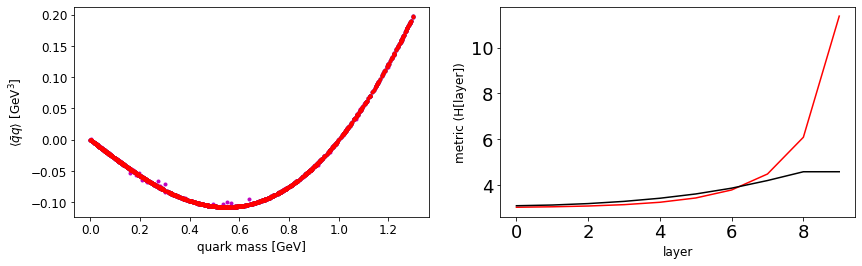

training epoch: 1300,   loss: 0.0006031951634213328
[3.09297, 3.124291, 3.1868646, 3.283524, 3.420369, 3.6077785, 3.8609774, 4.194775, 4.578183, 4.57905]


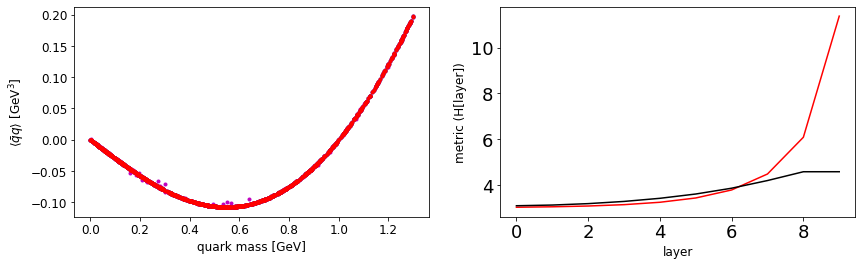

training epoch: 1400,   loss: 0.0005760126514360309
[3.0925531, 3.1232703, 3.18521, 3.2813528, 3.4179401, 3.6054778, 3.8592541, 4.194062, 4.5786195, 4.579333]


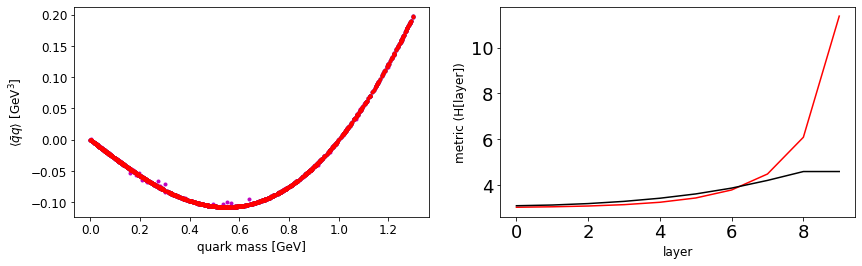

training epoch: 1500,   loss: 0.0005292228888720274
[3.093059, 3.1244094, 3.1870732, 3.2838721, 3.421045, 3.6092193, 3.8639333, 4.20032, 4.5873375, 4.587997]


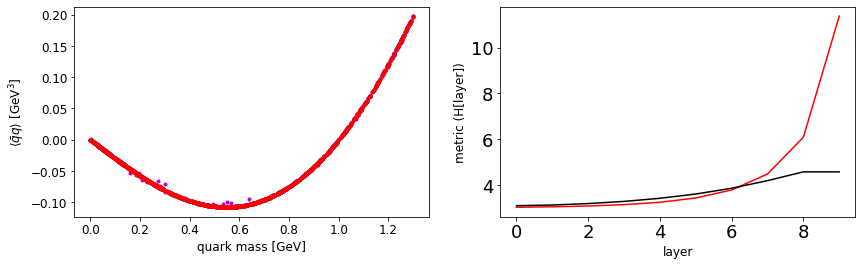

training epoch: 1600,   loss: 0.0005868528969585896
[3.0941975, 3.125019, 3.186864, 3.282554, 3.418287, 3.6045735, 3.8567948, 4.190004, 4.573458, 4.5727825]


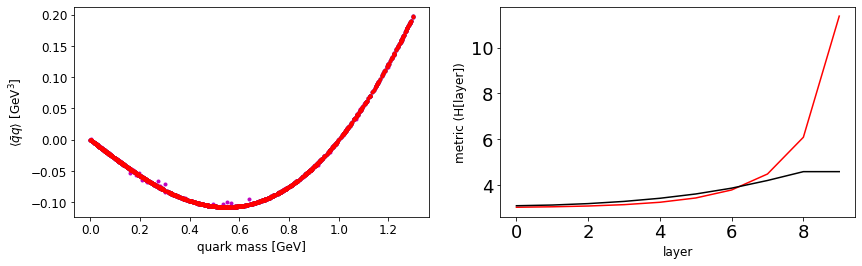

training epoch: 1700,   loss: 0.0005508336471393704
[3.092921, 3.1238296, 3.1859214, 3.2822602, 3.419143, 3.6070862, 3.8614056, 4.19698, 4.5826087, 4.583082]


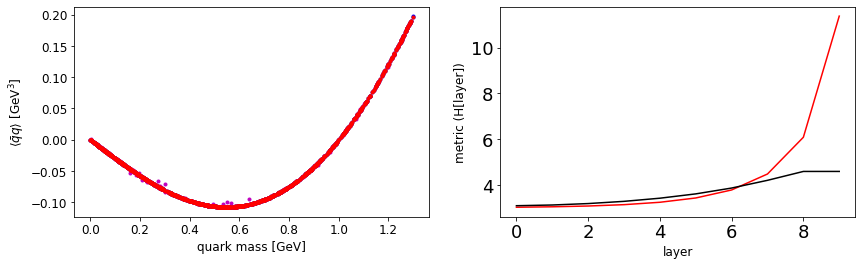

training epoch: 1800,   loss: 0.0005702304188162088
[3.0940201, 3.1253157, 3.1879854, 3.28492, 3.422412, 3.6110995, 3.866516, 4.203842, 4.5918717, 4.592418]


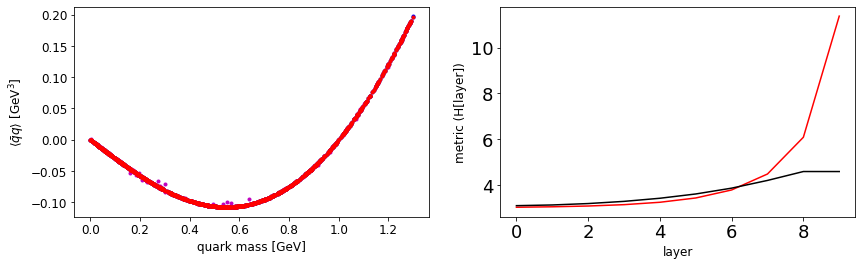

training epoch: 1900,   loss: 0.0006346998270601034
[3.0962057, 3.1268606, 3.1884482, 3.284009, 3.4200063, 3.607356, 3.8619318, 4.1992416, 4.5881486, 4.5874295]


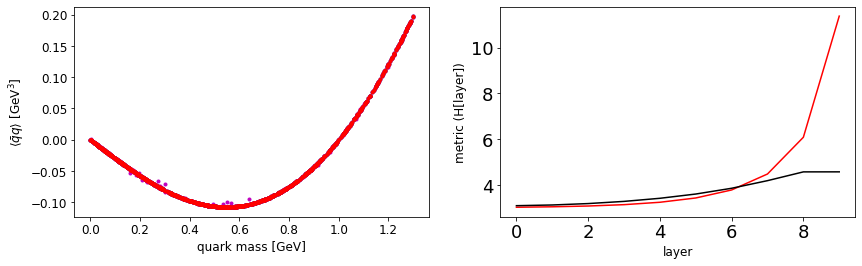

training epoch: 2000,   loss: 0.0005623219185508788
[3.0953457, 3.1260638, 3.1877286, 3.2831757, 3.4186175, 3.604572, 3.8564377, 4.1893244, 4.572641, 4.5738587]


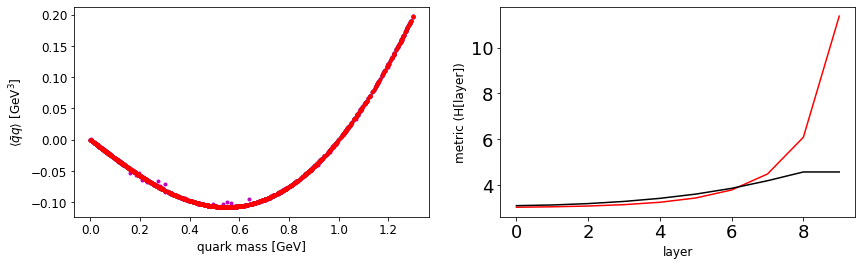

training epoch: 2100,   loss: 0.0005500274710357189
[3.0966947, 3.1263509, 3.1867297, 3.2811391, 3.4159086, 3.6015396, 3.8533099, 4.1860676, 4.5688753, 4.569034]


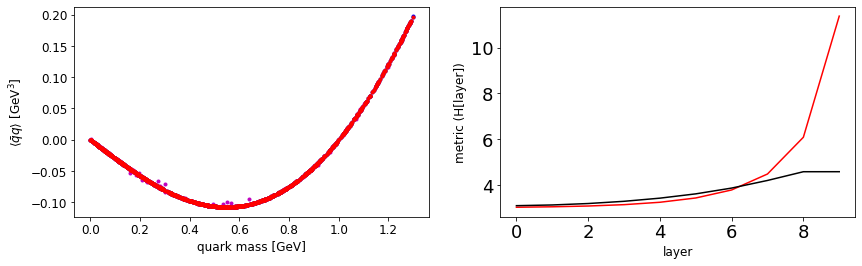

training epoch: 2200,   loss: 0.0005561070865951478
[3.0957336, 3.1268153, 3.1896062, 3.2868133, 3.4242797, 3.6121113, 3.8652048, 4.19805, 4.5796113, 4.580418]


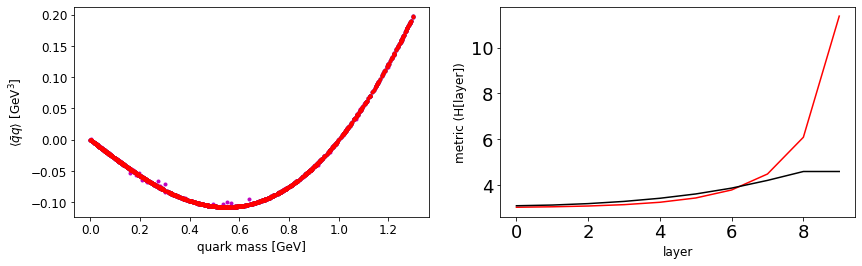

training epoch: 2300,   loss: 0.0005474540521390736
[3.0923178, 3.123305, 3.1855915, 3.282197, 3.4194338, 3.6079752, 3.863406, 4.200905, 4.58913, 4.589522]


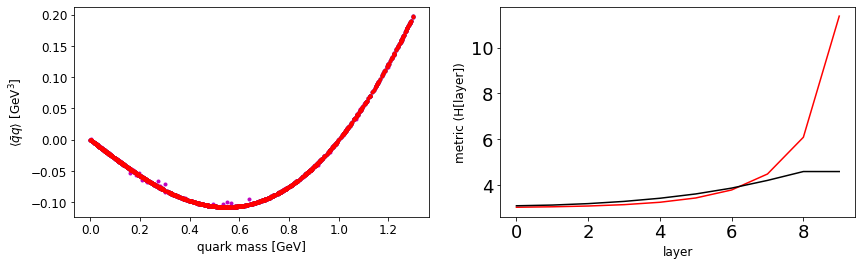

training epoch: 2400,   loss: 0.000715073139872402
[3.0910747, 3.122494, 3.1854045, 3.2824981, 3.4199755, 3.6084902, 3.8636005, 4.2004232, 4.587651, 4.58701]


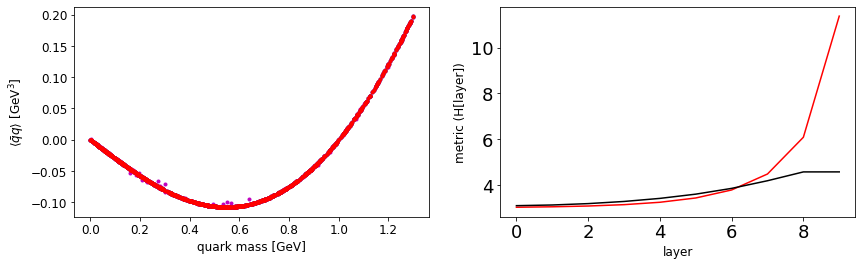

training epoch: 2500,   loss: 0.000566745875403285
[3.0959969, 3.1258268, 3.1860445, 3.2799885, 3.4142115, 3.5995274, 3.8516357, 4.1858907, 4.571434, 4.5721817]


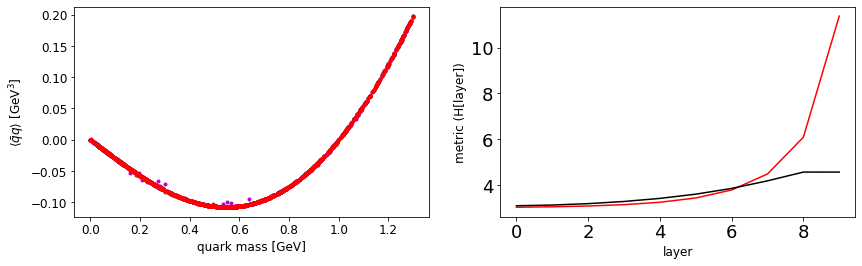

training epoch: 2600,   loss: 0.0005968653713352978
[3.0928288, 3.1235461, 3.184838, 3.2796237, 3.414181, 3.5990887, 3.8498025, 4.181472, 4.5636725, 4.5640135]


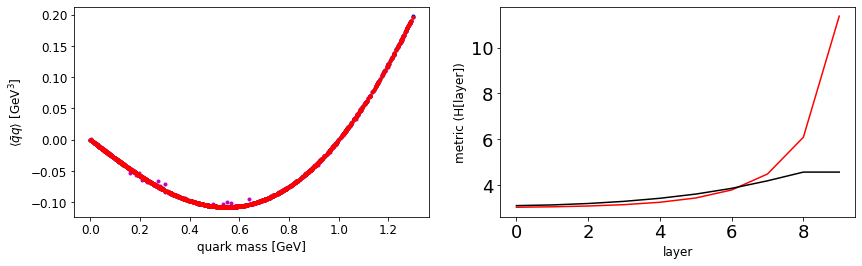

training epoch: 2700,   loss: 0.0005937408423051238
[3.0978796, 3.1288002, 3.19023, 3.2848313, 3.4187832, 3.6027005, 3.8521338, 4.1823473, 4.563081, 4.5637116]


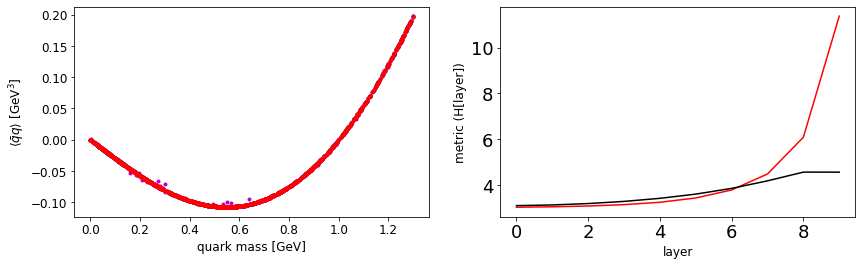

training epoch: 2800,   loss: 0.0005814489559270442
[3.0970275, 3.1272957, 3.1882424, 3.282762, 3.4169712, 3.6013217, 3.8511431, 4.1814666, 4.5619082, 4.5611744]


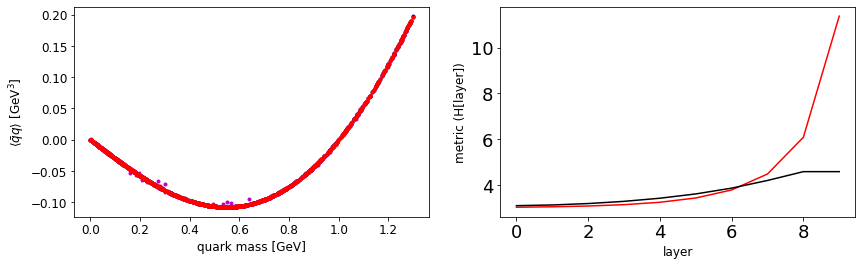

training epoch: 2900,   loss: 0.0005950141930952668
[3.095895, 3.1267958, 3.188794, 3.2849212, 3.4214463, 3.6089053, 3.8626773, 4.197757, 4.5830755, 4.583155]


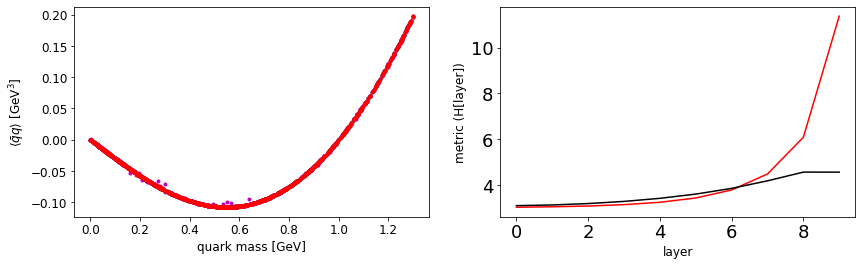

training epoch: 3000,   loss: 0.000581111409701407
[3.0966783, 3.1268885, 3.1877916, 3.2823987, 3.416896, 3.6016762, 3.8519173, 4.1824346, 4.5626264, 4.562127]


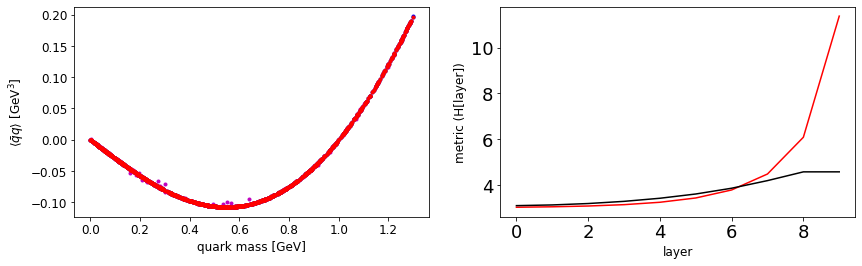

training epoch: 3100,   loss: 0.0005895528011023998
[3.0974762, 3.128101, 3.189439, 3.284623, 3.420042, 3.6062064, 3.8583124, 4.191104, 4.573568, 4.573999]


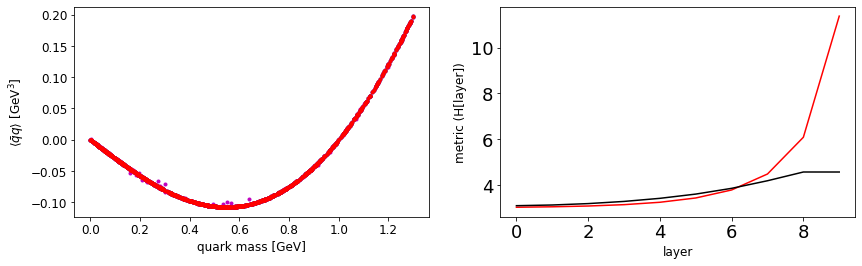

training epoch: 3200,   loss: 0.0006086781504563987
[3.0950265, 3.1255114, 3.1866114, 3.2815533, 3.4166381, 3.602272, 3.853622, 4.18553, 4.5673537, 4.566929]


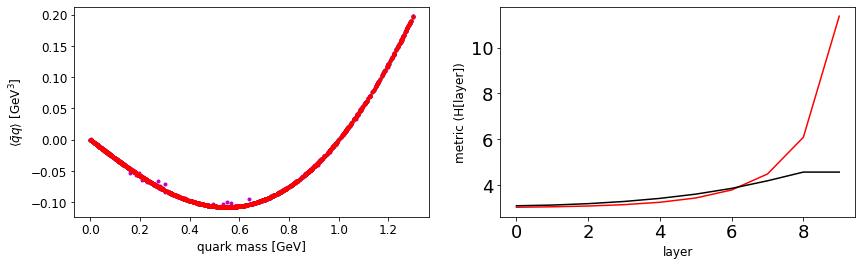

training epoch: 3300,   loss: 0.0006390857743099332
[3.0919023, 3.122402, 3.1838944, 3.279182, 3.4144094, 3.599996, 3.8511577, 4.182701, 4.5638204, 4.563728]


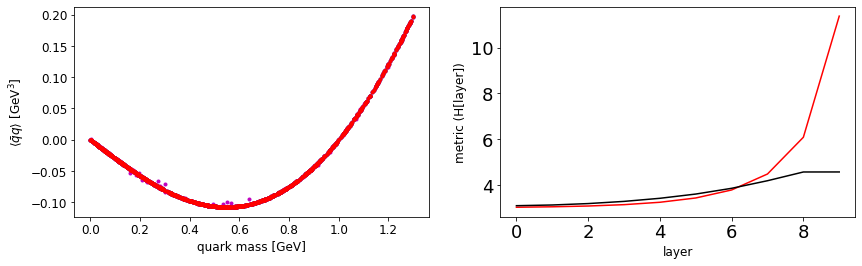

training epoch: 3400,   loss: 0.0005267362575978041
[3.094832, 3.1258023, 3.187601, 3.2830482, 3.4183028, 3.6038175, 3.8549016, 4.1865387, 4.568081, 4.5693207]


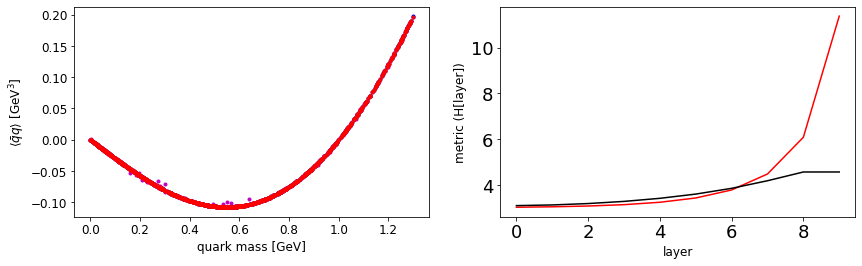

training epoch: 3500,   loss: 0.0006059130537323654
[3.09827, 3.1281378, 3.188633, 3.2829268, 3.4173803, 3.6025424, 3.85372, 4.1857824, 4.5678644, 4.5683236]


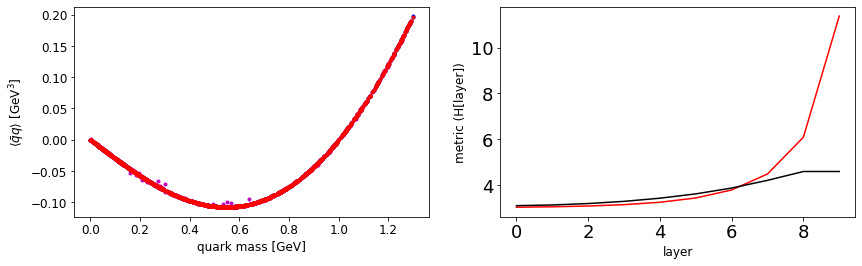

training epoch: 3600,   loss: 0.0005896594957448542
[3.0964358, 3.126846, 3.1885853, 3.284946, 3.4222221, 3.6108892, 3.866204, 4.2029176, 4.5894513, 4.589075]


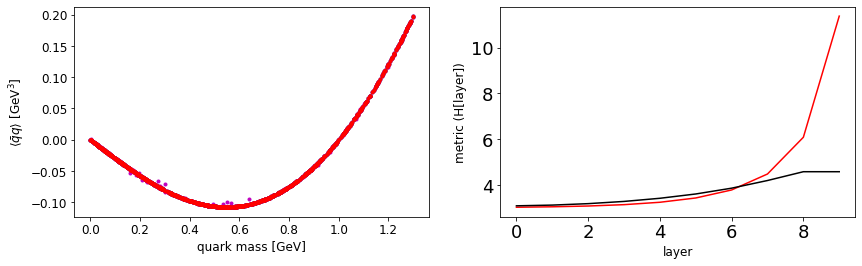

training epoch: 3700,   loss: 0.0005362097872421145
[3.0895748, 3.1212475, 3.184383, 3.2816348, 3.419029, 3.6069624, 3.8607721, 4.195464, 4.58006, 4.579698]


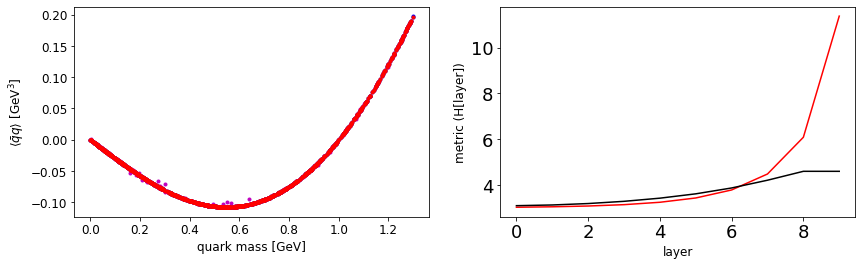

training epoch: 3800,   loss: 0.000654049392323941
[3.0957432, 3.12653, 3.188918, 3.2859561, 3.423901, 3.6133606, 3.8698478, 4.208432, 4.597538, 4.5969844]


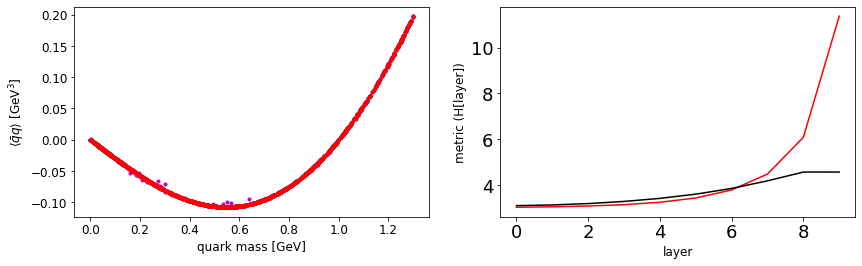

training epoch: 3900,   loss: 0.0006220937357284129
[3.097712, 3.1275775, 3.1878557, 3.281598, 3.4151552, 3.5992546, 3.84957, 4.181523, 4.5646977, 4.565375]


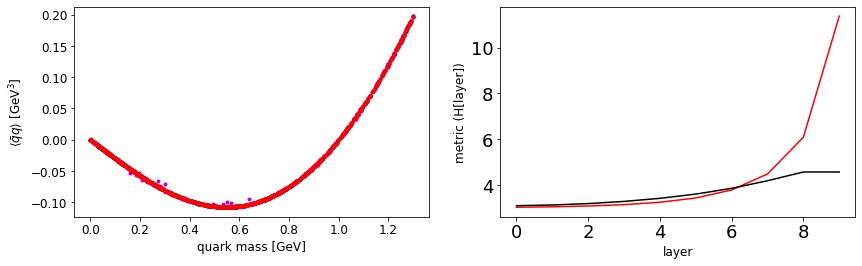

training epoch: 4000,   loss: 0.0005699498578906059
[3.0958734, 3.1259477, 3.1868808, 3.281729, 3.4167016, 3.602264, 3.8537083, 4.1859536, 4.5682073, 4.568494]


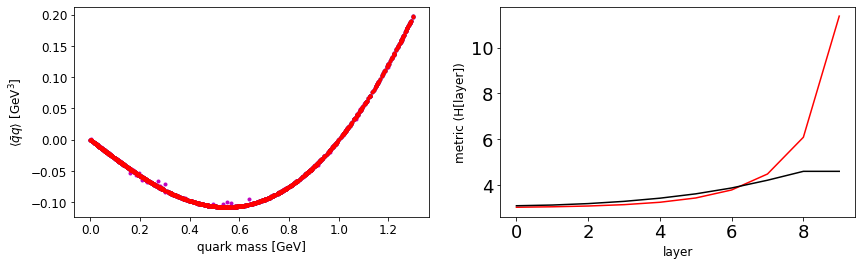

training epoch: 4100,   loss: 0.0006406445172615349
[3.0922642, 3.1235127, 3.1865375, 3.2842283, 3.4227793, 3.6127307, 3.869475, 4.207916, 4.596465, 4.5962214]


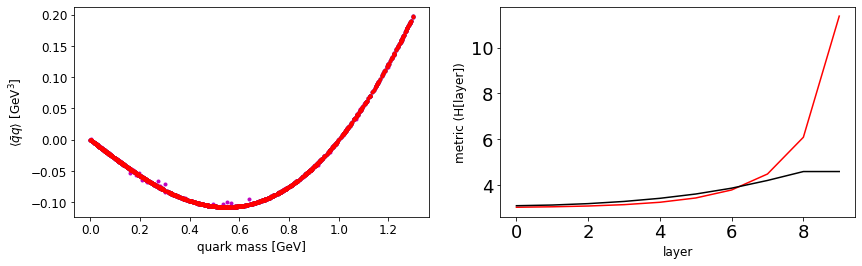

training epoch: 4200,   loss: 0.000624584557954222
[3.0938447, 3.1239154, 3.1851287, 3.280786, 3.4173124, 3.605424, 3.860725, 4.1984096, 4.587134, 4.587673]


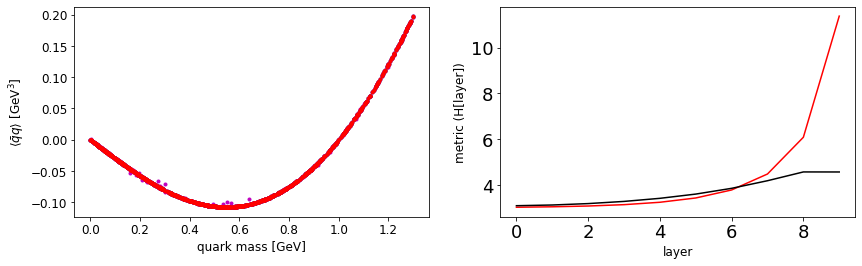

training epoch: 4300,   loss: 0.0005952861974947155
[3.0944197, 3.1253316, 3.1869755, 3.2821438, 3.4170847, 3.6024423, 3.853826, 4.1865864, 4.570226, 4.5684285]


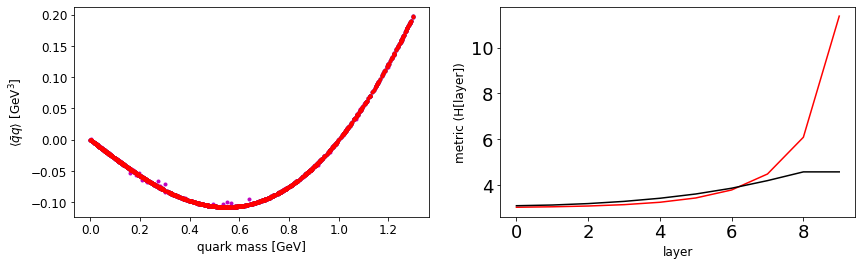

training epoch: 4400,   loss: 0.0005612038658000529
[3.0934322, 3.1245105, 3.1869318, 3.283314, 3.4196632, 3.6063213, 3.8584428, 4.190753, 4.5724235, 4.572782]


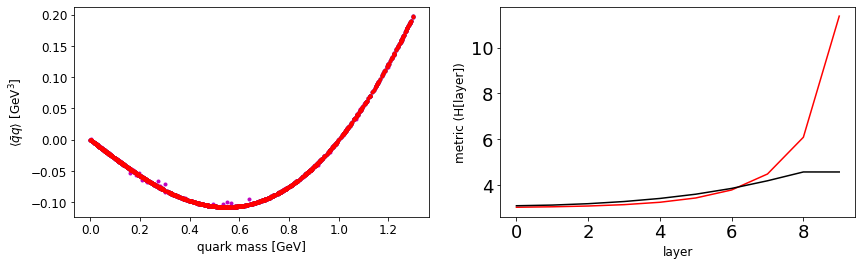

training epoch: 4500,   loss: 0.0005631337990052998
[3.092412, 3.1219301, 3.18234, 3.276738, 3.4114842, 3.5973039, 3.849787, 4.18407, 4.569084, 4.56861]


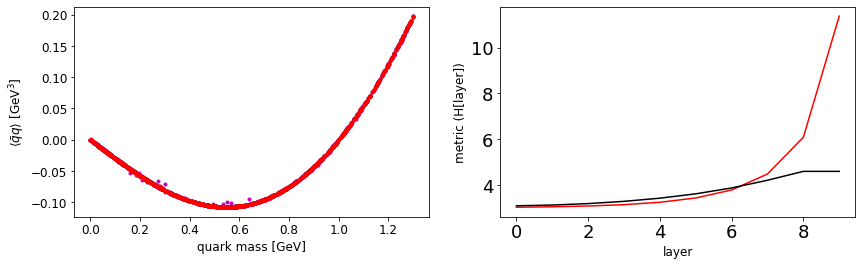

training epoch: 4600,   loss: 0.0005617171991616488
[3.0910106, 3.1231062, 3.1868231, 3.2848928, 3.4235313, 3.6132748, 3.869544, 4.207359, 4.595467, 4.595377]


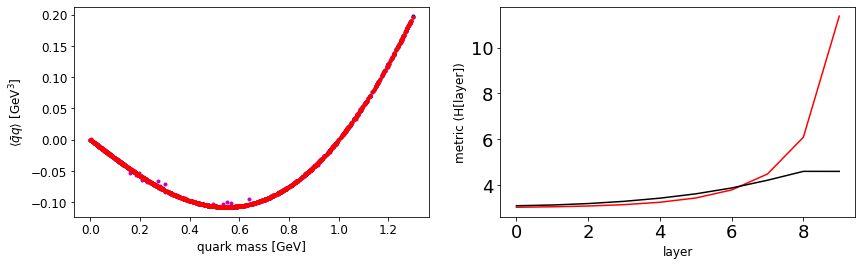

training epoch: 4700,   loss: 0.0006040417938493192
[3.0929675, 3.124524, 3.1877103, 3.2852528, 3.4233828, 3.6127653, 3.8689566, 4.2070394, 4.5956235, 4.594603]


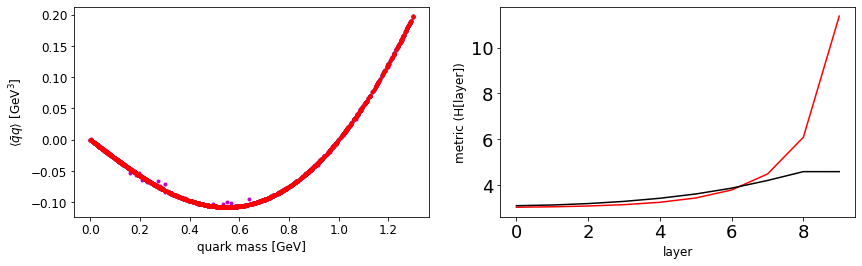

training epoch: 4800,   loss: 0.0006354356883093715
[3.094646, 3.125305, 3.187184, 3.2831662, 3.4195223, 3.6069205, 3.8609428, 4.196805, 4.5833645, 4.5826483]


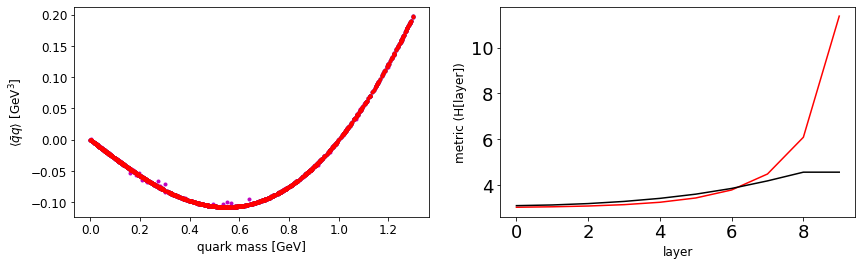

training epoch: 4900,   loss: 0.0006445874460041523
[3.0971289, 3.1269517, 3.1873558, 3.2813878, 3.4151752, 3.5991833, 3.8488142, 4.179163, 4.5597763, 4.560006]


In [71]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print(Test.show_Hs())
    

In [73]:
print(Test.show_Hs())

[3.0925634, 3.1228693, 3.1840646, 3.2791314, 3.4142761, 3.5998774, 3.8510523, 4.1825275, 4.5635753, 4.563244]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [0]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [0]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [0]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [0]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [0]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [0]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
